In [2]:
import pandas as pd
import pytz
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from eda import *
import prediction as dp

In [34]:
df , _ = load_data()

2024-10-08 13:01:33,116 - INFO - Loading Data ...


2024-10-08 13:01:33,475 - INFO - Loading Data Finshed


In [4]:
df.columns

Index(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId',
       'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'TransactionStartTime', 'PricingStrategy', 'FraudResult'],
      dtype='object')

In [35]:
# Convert the 'transaction_start_time' to datetime and localize to UTC
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime']).dt.tz_convert('UTC')


In [36]:
end_date = df['TransactionStartTime'].max()
# dff['rec'] = end_date - df['TransactionStartTime'] 
# dff['Recency'] = dff['rec'].dt.days


In [37]:
df['TransactionYear'] =  df['TransactionStartTime'].dt.year
df['TransactionMonth'] = df['TransactionStartTime'].dt.month
df['TransactionDay'] = df['TransactionStartTime'].dt.day
df['TransactionHour'] = df['TransactionStartTime'].dt.hour

In [52]:
import pandas as pd
import numpy as np

# # Sample Data
# data = {
#     'CustomerId': [1, 1, 2, 2, 3, 3, 4, 4],
#     'TransactionStartTime': ['2024-07-01', '2024-09-20', '2024-05-10', '2024-09-01', 
#                      '2024-01-01', '2024-03-15', '2024-06-15', '2024-08-25'],
#     'Amount': [100, -20, 150, 200, 50, -10, 300, -100]
# }

# df = pd.DataFrame(data)
# df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# # Set the analysis date (today's date)
# max_date = pd.Timestamp('2024-10-01')

# Step 1: Recency Calculation
recency_df = df.groupby('CustomerId').agg({'TransactionStartTime': lambda x: (end_date - x.max()).days})
recency_df.rename(columns={'TransactionStartTime': 'Recency'}, inplace=True)

# Normalize Recency (invert it so that more recent purchases get higher scores)
recency_df['RecencyNorm'] = 1 - (recency_df['Recency'] - recency_df['Recency'].min()) / (recency_df['Recency'].max() - recency_df['Recency'].min())

# Step 2: Frequency Calculation (number of purchases)
frequency_df = df.groupby('CustomerId').agg({'TransactionId': 'nunique'})
frequency_df.rename(columns={'TransactionId': 'Frequency'}, inplace=True)

# Normalize Frequency
frequency_df['FrequencyNorm'] = (frequency_df['Frequency'] - frequency_df['Frequency'].min()) / (frequency_df['Frequency'].max() - frequency_df['Frequency'].min())

# Step 3: Monetary Calculation (sum of debits and credits)
monetary_df = df.groupby('CustomerId').agg({'Amount': 'sum'})
monetary_df.rename(columns={'Amount': 'NetMonetary'}, inplace=True)

# # Option 1: Set negative values (credits) to zero
# monetary_df['NetMonetary'] = monetary_df['NetMonetary'].apply(lambda x: max(0, x))

# Normalize Monetary
monetary_df['MonetaryNorm'] = (monetary_df['NetMonetary'] - monetary_df['NetMonetary'].min()) / (monetary_df['NetMonetary'].max() - monetary_df['NetMonetary'].min())

# Step 4: Merge Recency, Frequency, and Monetary into a single RFM DataFrame
rfm = recency_df.merge(frequency_df, on='CustomerId').merge(monetary_df, on='CustomerId')

# Step 5: Calculate the overall RFM score (average of normalized values)
rfm['RFM_Score'] = (rfm['RecencyNorm'] + rfm['FrequencyNorm'] + rfm['MonetaryNorm']) / 3

# Step 6: Classify customers into two groups based on the median RFM score
rfm['Risk'] = rfm['RFM_Score'].apply(lambda x: 'Good' if x >= 0.5 else 'Bad') # rfm['RFM_Score'].median()
rfm['Bad'] = rfm['RFM_Score'].apply(lambda x: '0' if x >= 0.5 else '1')

# Final RFM DataFrame
rfm


,Recency,RecencyNorm,Frequency,FrequencyNorm,NetMonetary,MonetaryNorm,RFM_Score,Risk,Bad
CustomerId,,,,,,,,,
CustomerId_1,83,0.077778,1,0.000000,-10000.0,0.556885,0.211554,Bad,1
CustomerId_10,83,0.077778,1,0.000000,-10000.0,0.556885,0.211554,Bad,1
CustomerId_1001,89,0.011111,5,0.000978,20000.0,0.557044,0.189711,Bad,1
CustomerId_1002,25,0.722222,11,0.002445,4225.0,0.556961,0.427209,Bad,1
CustomerId_1003,11,0.877778,6,0.001222,20000.0,0.557044,0.478682,Bad,1
...,...,...,...,...,...,...,...,...,...
CustomerId_992,4,0.955556,6,0.001222,20000.0,0.557044,0.504607,Good,0
CustomerId_993,25,0.722222,5,0.000978,20000.0,0.557044,0.426748,Bad,1
CustomerId_994,0,1.000000,101,0.024450,543873.0,0.559826,0.528092,Good,0


In [64]:
rfm.head()

,CustomerId,Recency,RecencyNorm,Frequency,FrequencyNorm,NetMonetary,MonetaryNorm,RFM_Score,Risk,Bad,RecencyQuartile,FrequencyQuartile,MonetaryQuartile,RFM_Score2,risk_g
0,CustomerId_1,83,0.077778,1,0.000000,-10000.0,0.556885,0.211554,Bad,1,1,1,1,3,1
1,CustomerId_10,83,0.077778,1,0.000000,-10000.0,0.556885,0.211554,Bad,1,1,1,1,3,1
2,CustomerId_1001,89,0.011111,5,0.000978,20000.0,0.557044,0.189711,Bad,1,1,2,2,5,1
3,CustomerId_1002,25,0.722222,11,0.002445,4225.0,0.556961,0.427209,Bad,1,2,3,2,7,1
4,CustomerId_1003,11,0.877778,6,0.001222,20000.0,0.557044,0.478682,Bad,1,3,2,2,7,1


In [74]:
rfm['risk_g'].value_counts()

risk_g
0    2185
1    1557
Name: count, dtype: int64

In [66]:
rfm['RFM_Score2'].value_counts()

RFM_Score2
6     528
7     427
4     404
12    398
5     373
8     371
10    347
9     331
11    311
3     252
Name: count, dtype: int64

In [72]:

# Recency: Customers with lower recency values are better, so quartiles are inverted
rfm['RecencyQuartile'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])

# Frequency: Higher frequency is better, so quartiles are straight
rfm['FrequencyQuartile'] = pd.qcut(rfm['Frequency'], q=4, labels=[1, 2, 3, 4])

# Monetary: Higher monetary value is better, so quartiles are straight
rfm['MonetaryQuartile'] = pd.qcut(rfm['NetMonetary'], q=4, labels=[1, 2, 3, 4])

# Step 6: Sum the quartile scores to calculate the total RFM score
rfm['RFM_Score2'] = rfm['RecencyQuartile'].astype(int) + rfm['FrequencyQuartile'].astype(int) + rfm['MonetaryQuartile'].astype(int)

# For example, RFM_Score <= 6 -> "Low Value", RFM_Score > 6 -> "High Value"
rfm['risk_g'] = rfm['RFM_Score2'].apply(lambda x: '0' if x > 6 else '1')


In [51]:
rfm['RFM_Score'].median()

0.43379554110752905

In [50]:
rfm['Risk'].value_counts()

Risk
Bad     1871
Good    1871
Name: count, dtype: int64

In [23]:
rfm

,CustomerId,Recency,RecencyNorm,Frequency,FrequencyNorm,NetMonetary,MonetaryNorm,RFM_Score,Risk
0,CustomerId_1,83,0.077778,1,0.000000,-10000.0,0.556885,0.211554,Bad
1,CustomerId_10,83,0.077778,1,0.000000,-10000.0,0.556885,0.211554,Bad
2,CustomerId_1001,89,0.011111,5,0.000978,20000.0,0.557044,0.189711,Bad
3,CustomerId_1002,25,0.722222,11,0.002445,4225.0,0.556961,0.427209,Bad
4,CustomerId_1003,11,0.877778,6,0.001222,20000.0,0.557044,0.478682,Good
...,...,...,...,...,...,...,...,...,...
3737,CustomerId_992,4,0.955556,6,0.001222,20000.0,0.557044,0.504607,Good
3738,CustomerId_993,25,0.722222,5,0.000978,20000.0,0.557044,0.426748,Bad
3739,CustomerId_994,0,1.000000,101,0.024450,543873.0,0.559826,0.528092,Good
3740,CustomerId_996,67,0.255556,17,0.003912,139000.0,0.557676,0.272381,Bad


In [53]:
rfm.reset_index(inplace=True)

In [54]:

# Step 2: Select necessary columns from the RFM DataFrame
rfm_classification = rfm[['CustomerId', 'Recency', 'Frequency', 'NetMonetary', 'Bad']]

# Step 3: Merge the RFM classification with the original transaction data
df_with_rfm_features = df.merge(rfm_classification, on='CustomerId', how='left')

# Step 4: Display the merged data
df_with_rfm_features.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,Recency,Frequency,NetMonetary,Bad
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0,2018,11,15,2,0,119,109921.75,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0,2018,11,15,2,0,119,109921.75,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0,2018,11,15,2,81,2,1000.00,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0,2018,11,15,3,5,38,228727.20,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0,2018,11,15,3,5,38,228727.20,0


In [55]:
df_with_rfm_features.shape

(95662, 24)

In [92]:
dff = df_with_rfm_features.copy()

In [93]:
dff.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
       'CurrencyCode', 'CountryCode', 'Value', 'TransactionStartTime'
        ], axis=1 , inplace=True) 

In [94]:
dff['Bad'] = dff['Bad'].astype(int)

In [78]:
dff.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,PricingStrategy,FraudResult,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,Recency,Frequency,NetMonetary,Bad
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,2,0,2018,11,15,2,0,119,109921.75,0
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,2,0,2018,11,15,2,0,119,109921.75,0
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,2,0,2018,11,15,2,81,2,1000.00,1
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,2,0,2018,11,15,3,5,38,228727.20,0
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,2,0,2018,11,15,3,5,38,228727.20,0


In [79]:
dff.dtypes

ProviderId           object
ProductId            object
ProductCategory      object
ChannelId            object
Amount              float64
PricingStrategy       int64
FraudResult           int64
TransactionYear       int32
TransactionMonth      int32
TransactionDay        int32
TransactionHour       int32
Recency               int64
Frequency             int64
NetMonetary         float64
Bad                   int32
dtype: object

## Woe and Iv 

In [49]:
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning

In [95]:
# Perform a 70 / 30 split of data
train, test = sc.split_df(dff, 'Bad', ratio = 0.8, seed = 999).values()

In [91]:
train

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,PricingStrategy,FraudResult,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,Recency,Frequency,NetMonetary,Bad
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,2,0,2018,11,15,2,0,119,109921.75,0
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,2,0,2018,11,15,2,0,119,109921.75,0
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,2,0,2018,11,15,2,81,2,1000.00,1
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,2,0,2018,11,15,3,5,38,228727.20,0
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,2,0,2018,11,15,3,5,38,228727.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,2,0,2019,2,13,9,0,573,2438140.00,0
95658,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,2,0,2019,2,13,9,0,43,58499.60,0
95659,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,2,0,2019,2,13,9,0,43,58499.60,0
95660,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,2,0,2019,2,13,10,0,524,851985.00,0


In [85]:
type(var)

pandas.core.indexes.base.Index

In [96]:

var = train.drop(['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Bad'], axis = 1).columns
y_var = train['Bad']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 10, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks
  breaks = {}
  for i in x:
    bin_object.fit(train[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks

var

Index(['Amount', 'PricingStrategy', 'FraudResult', 'TransactionYear', 'TransactionMonth', 'TransactionDay', 'TransactionHour', 'Recency', 'Frequency', 'NetMonetary'], dtype='object')

In [97]:
woe_num(var, 'Bad')

{'Amount': [-25000.0,
  -14999.0,
  -12500.0,
  -9500.0,
  -5000.0,
  -42.0,
  3800.0,
  44500.0,
  49750.0,
  61057.0,
  9880000.0],
 'PricingStrategy': [4.0],
 'FraudResult': [0.0, 1.0],
 'TransactionYear': [2019.0],
 'TransactionMonth': [2.0, 12.0],
 'TransactionDay': [8.0, 12.0, 13.0, 31.0],
 'TransactionHour': [5.0, 11.0, 19.0, 20.0, 21.0, 23.0],
 'Recency': [6.0, 7.0, 10.0, 33.0, 90.0],
 'Frequency': [4091.0],
 'NetMonetary': [-291000.0, 29726020.0, 83451240.0]}

In [98]:
# Check categorical variables names
bins = sc.woebin(train, y = 'Bad', x = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId'], save_breaks_list = 'cat_breaks')

[INFO] creating woe binning ...
[INFO] The breaks_list is saved as cat_breaks_20241008_140557.py


In [99]:
# import dictionary
from cat_breaks_20241008_140557 import breaks_list
breaks_list

# merge
breaks.update(breaks_list)
print(breaks)

{'Amount': [-25000.0, -14999.0, -12500.0, -9500.0, -5000.0, -42.0, 3800.0, 44500.0, 49750.0, 61057.0, 9880000.0], 'PricingStrategy': [4.0], 'FraudResult': [0.0, 1.0], 'TransactionYear': [2019.0], 'TransactionMonth': [2.0, 12.0], 'TransactionDay': [8.0, 12.0, 13.0, 31.0], 'TransactionHour': [5.0, 11.0, 19.0, 20.0, 21.0, 23.0], 'Recency': [6.0, 7.0, 10.0, 33.0, 90.0], 'Frequency': [4091.0], 'NetMonetary': [-291000.0, 29726020.0, 83451240.0], 'ChannelId': ['ChannelId_5%,%ChannelId_2', 'ChannelId_3%,%ChannelId_1'], 'ProductCategory': ['tv%,%airtime%,%utility_bill', 'financial_services%,%data_bundles%,%movies%,%ticket%,%transport%,%other'], 'ProductId': ['ProductId_23%,%ProductId_22%,%ProductId_14%,%ProductId_19%,%ProductId_3%,%ProductId_8', 'ProductId_13%,%ProductId_10%,%ProductId_6%,%ProductId_21%,%ProductId_11', 'ProductId_1%,%ProductId_2%,%ProductId_4', 'ProductId_15%,%ProductId_27%,%ProductId_16%,%ProductId_7%,%ProductId_24%,%ProductId_20%,%ProductId_5%,%ProductId_12%,%ProductId_9'], '

In [101]:
bins_adj = sc.woebin(dff, 'Bad', breaks_list= breaks, positive = 'bad|0') # change positive to adjust WOE to ln(GOOD / BAD)

[INFO] creating woe binning ...


{'ProductId': <Figure size 640x480 with 2 Axes>,
 'NetMonetary': <Figure size 640x480 with 2 Axes>,
 'TransactionYear': <Figure size 640x480 with 2 Axes>,
 'Recency': <Figure size 640x480 with 2 Axes>,
 'FraudResult': <Figure size 640x480 with 2 Axes>,
 'Amount': <Figure size 640x480 with 2 Axes>,
 'ProviderId': <Figure size 640x480 with 2 Axes>,
 'TransactionDay': <Figure size 640x480 with 2 Axes>,
 'PricingStrategy': <Figure size 640x480 with 2 Axes>,
 'ProductCategory': <Figure size 640x480 with 2 Axes>,
 'TransactionHour': <Figure size 640x480 with 2 Axes>,
 'TransactionMonth': <Figure size 640x480 with 2 Axes>,
 'Frequency': <Figure size 640x480 with 2 Axes>,
 'ChannelId': <Figure size 640x480 with 2 Axes>}

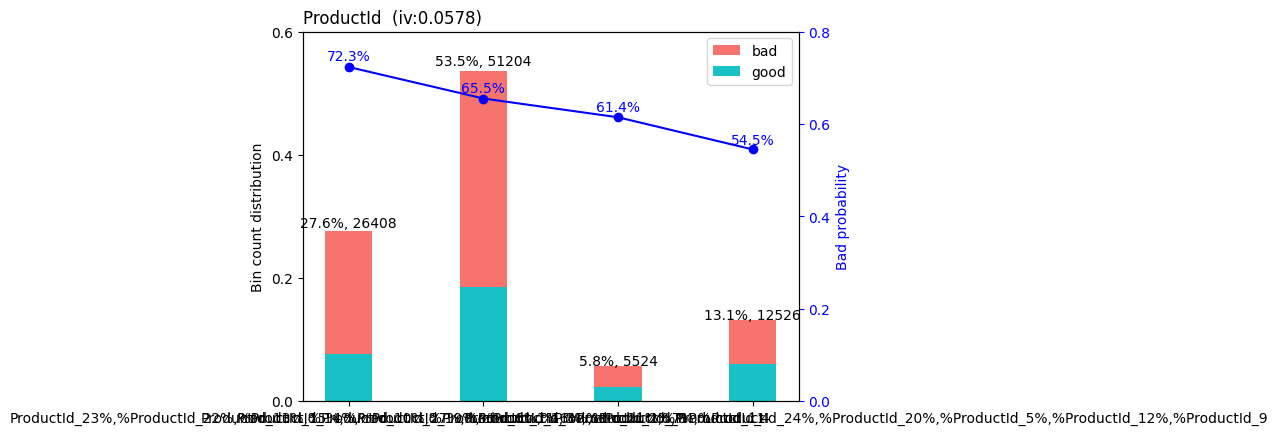

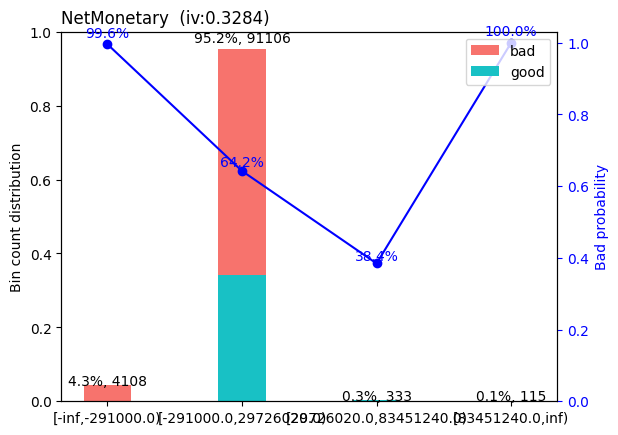

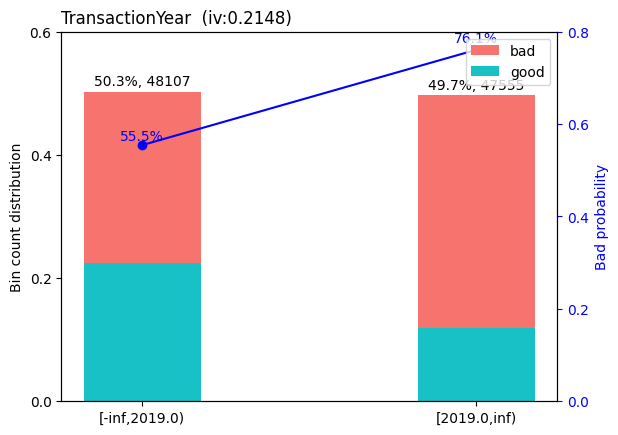

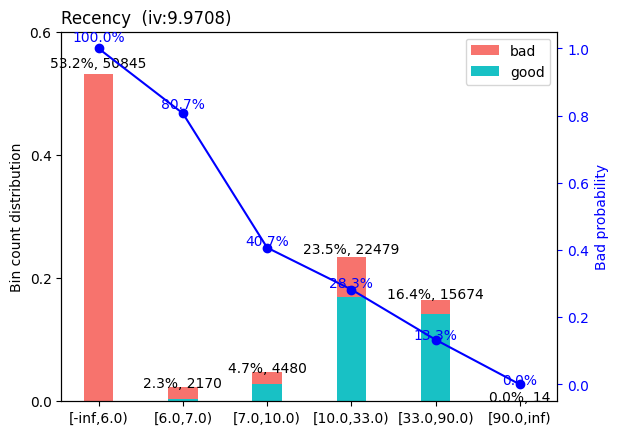

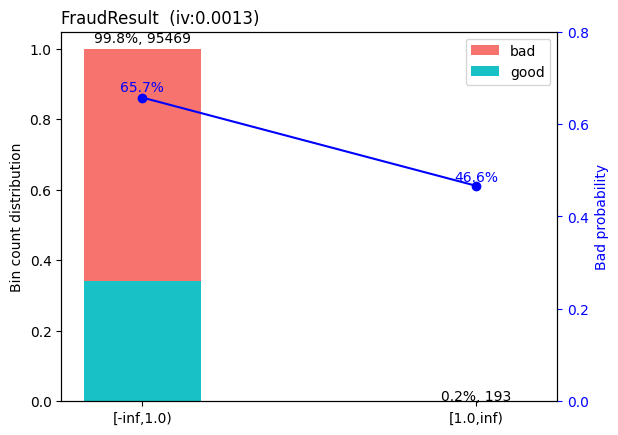

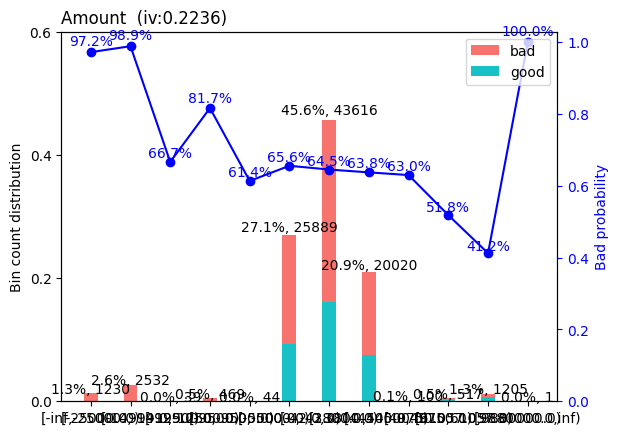

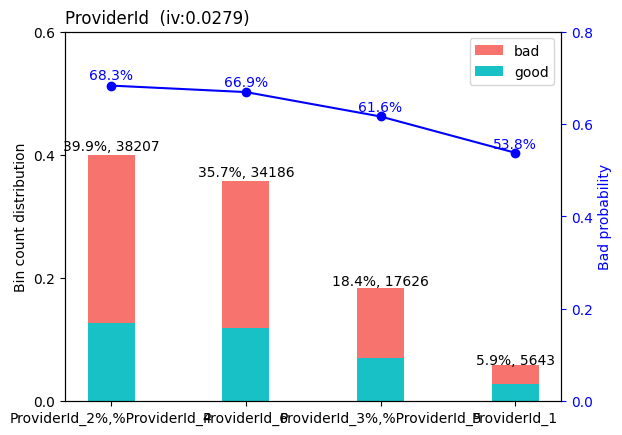

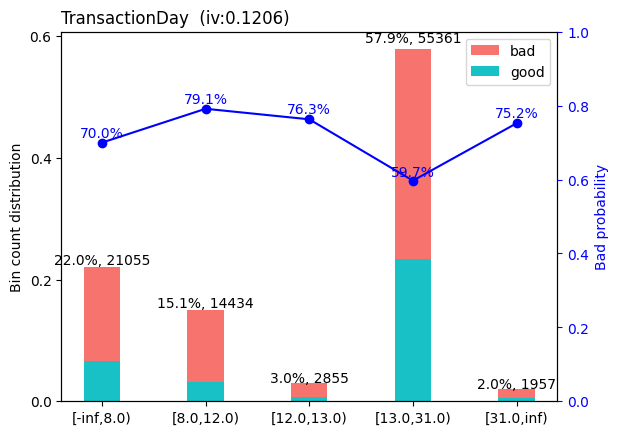

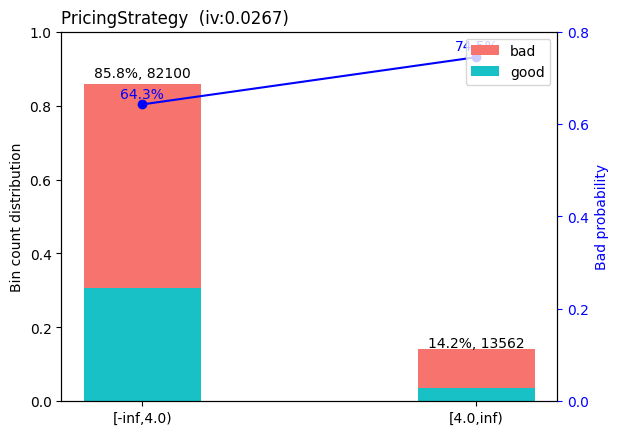

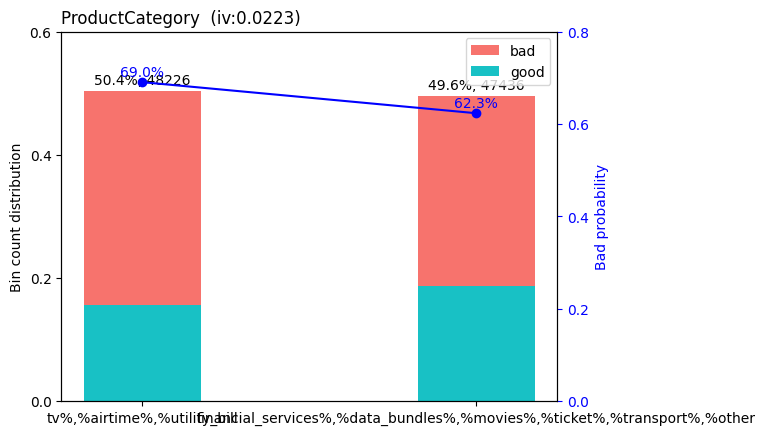

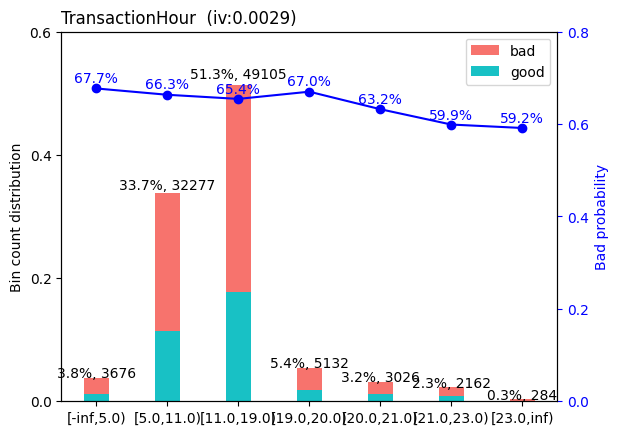

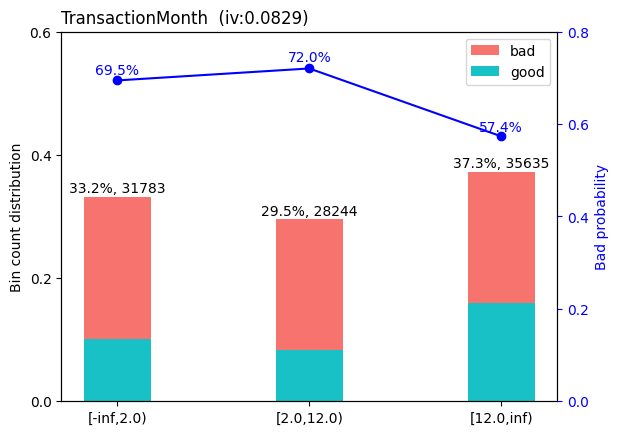

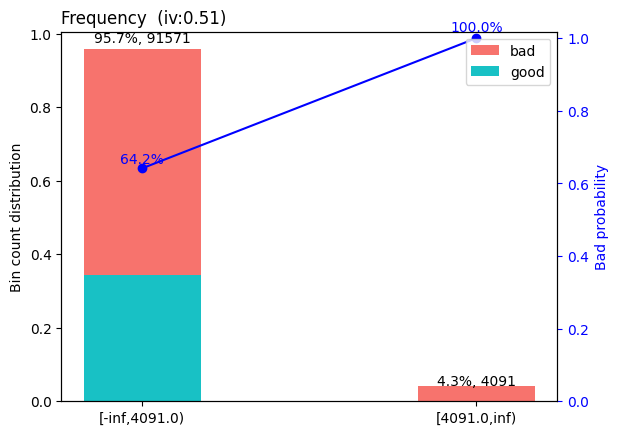

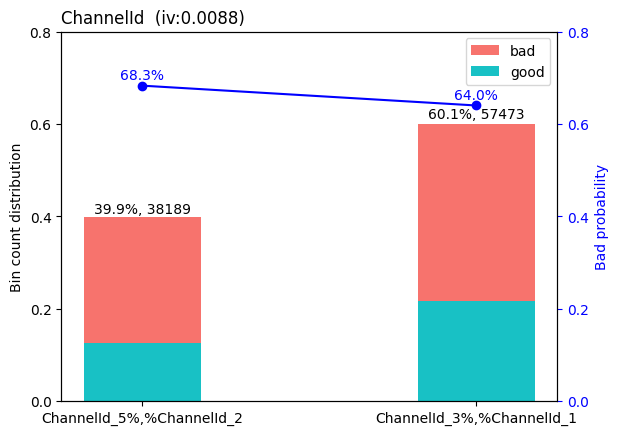

In [102]:
sc.woebin_plot(bins_adj)

In [103]:
train_woe = sc.woebin_ply(train, bins_adj)

[INFO] converting into woe values ...


In [104]:
train_woe

,Bad,ProductId_woe,NetMonetary_woe,TransactionYear_woe,Recency_woe,FraudResult_woe,Amount_woe,ProviderId_woe,TransactionDay_woe,PricingStrategy_woe,ProductCategory_woe,TransactionHour_woe,TransactionMonth_woe,Frequency_woe,ChannelId_woe
0,0,-0.008985,-0.064625,-0.431356,10.291629,0.001712,-0.051451,0.053195,-0.25749,-0.063692,0.151783,0.090171,0.295993,-0.067271,-0.075198
1,0,-0.008985,-0.064625,-0.431356,10.291629,0.001712,-0.051451,0.117145,-0.25749,-0.063692,-0.147229,0.090171,0.295993,-0.067271,0.116697
2,1,-0.184394,-0.064625,-0.431356,-2.524760,0.001712,-0.051451,0.053195,-0.25749,-0.063692,0.151783,0.090171,0.295993,-0.067271,-0.075198
3,0,-0.008985,-0.064625,-0.431356,10.291629,0.001712,-0.085670,-0.499366,-0.25749,-0.063692,0.151783,0.090171,0.295993,-0.067271,-0.075198
4,0,-0.008985,-0.064625,-0.431356,10.291629,0.001712,-0.005280,0.117145,-0.25749,-0.063692,-0.147229,0.090171,0.295993,-0.067271,0.116697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,0,-0.008985,-0.064625,0.506923,10.291629,0.001712,-0.005280,0.117145,-0.25749,-0.063692,-0.147229,0.028401,0.295993,-0.067271,0.116697
95658,0,-0.008985,-0.064625,0.506923,10.291629,0.001712,-0.051451,0.053195,-0.25749,-0.063692,0.151783,0.028401,0.295993,-0.067271,-0.075198
95659,0,-0.008985,-0.064625,0.506923,10.291629,0.001712,-0.051451,0.117145,-0.25749,-0.063692,-0.147229,0.028401,0.295993,-0.067271,0.116697
95660,0,0.309870,-0.064625,0.506923,10.291629,0.001712,-0.051451,0.053195,-0.25749,-0.063692,0.151783,0.028401,0.295993,-0.067271,-0.075198


In [105]:
train_woe['Bad'].value_counts()

Bad
0    50286
1    26244
Name: count, dtype: int64

In [107]:
dff.columns

Index(['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'PricingStrategy', 'FraudResult', 'TransactionYear', 'TransactionMonth', 'TransactionDay', 'TransactionHour', 'Recency', 'Frequency', 'NetMonetary', 'Bad'], dtype='object')

In [111]:
# # List of columns to drop
# columns_to_drop = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'TransactionStartTime']

# # Drop the specified columns
# df_dropped = dff.drop(columns=columns_to_drop)

binss = sc.woebin(dff,'Bad')

[INFO] creating woe binning ...


{'ProductId': <Figure size 640x480 with 2 Axes>,
 'NetMonetary': <Figure size 640x480 with 2 Axes>,
 'TransactionYear': <Figure size 640x480 with 2 Axes>,
 'Recency': <Figure size 640x480 with 2 Axes>,
 'FraudResult': <Figure size 640x480 with 2 Axes>,
 'Amount': <Figure size 640x480 with 2 Axes>,
 'ProviderId': <Figure size 640x480 with 2 Axes>,
 'TransactionDay': <Figure size 640x480 with 2 Axes>,
 'PricingStrategy': <Figure size 640x480 with 2 Axes>,
 'ProductCategory': <Figure size 640x480 with 2 Axes>,
 'TransactionHour': <Figure size 640x480 with 2 Axes>,
 'TransactionMonth': <Figure size 640x480 with 2 Axes>,
 'Frequency': <Figure size 640x480 with 2 Axes>,
 'ChannelId': <Figure size 640x480 with 2 Axes>}

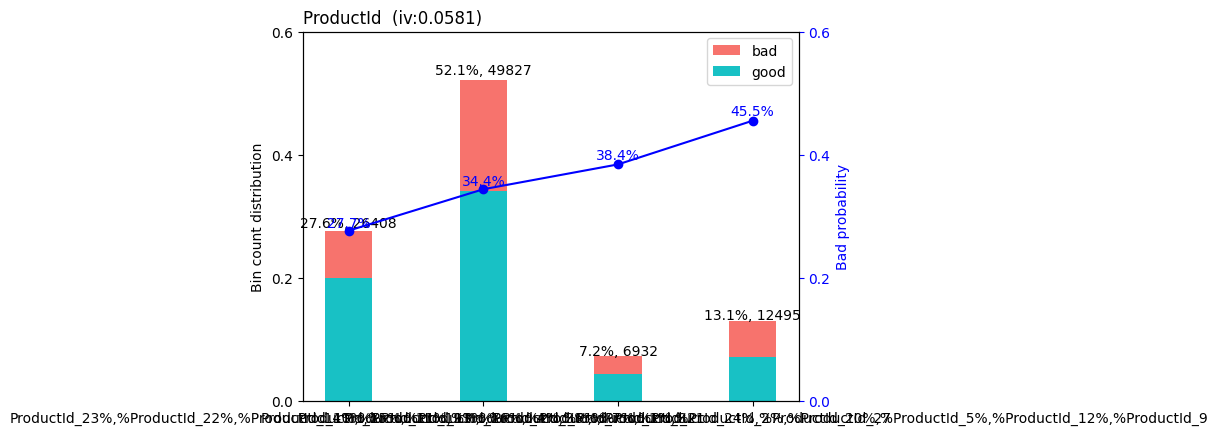

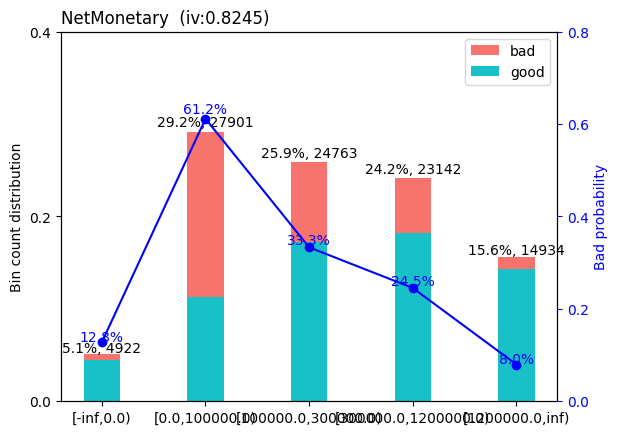

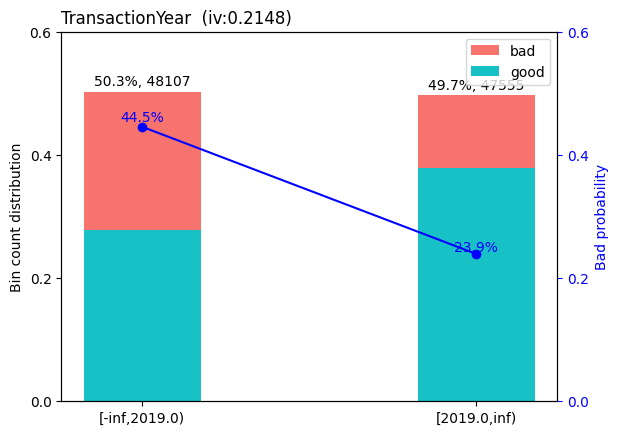

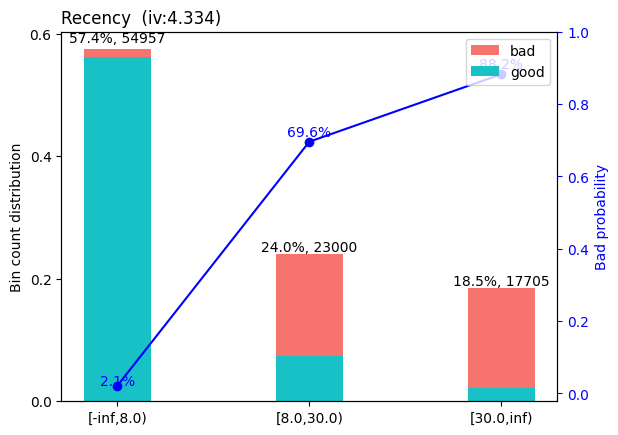

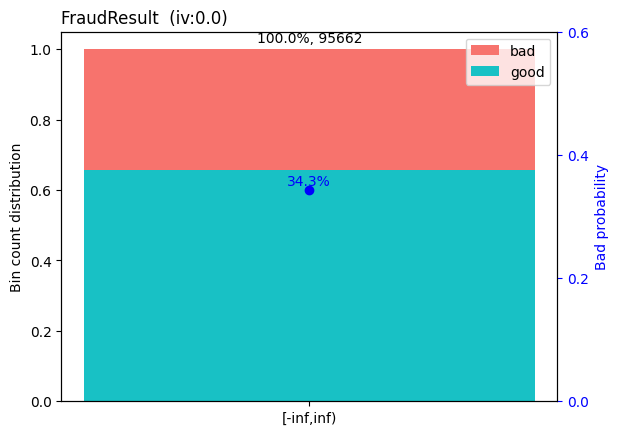

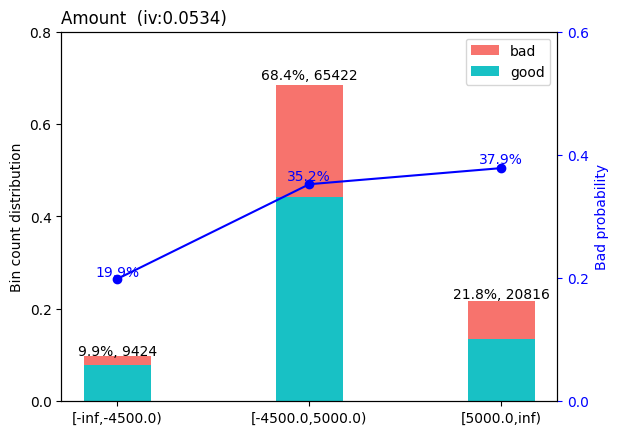

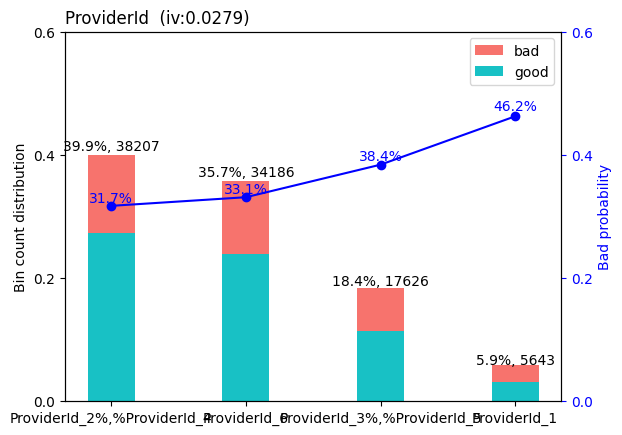

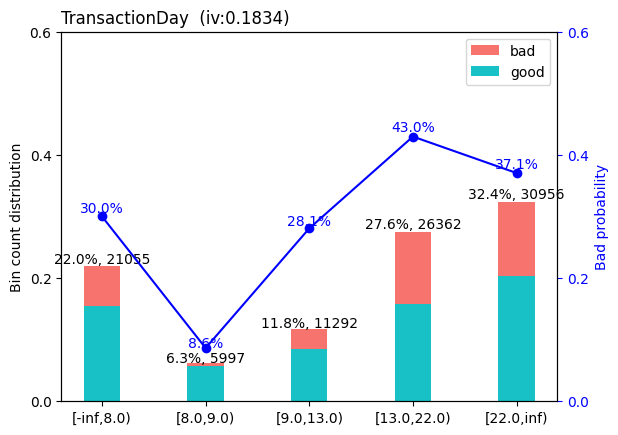

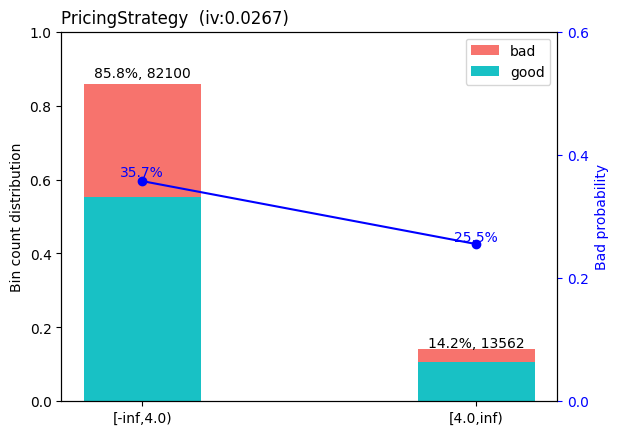

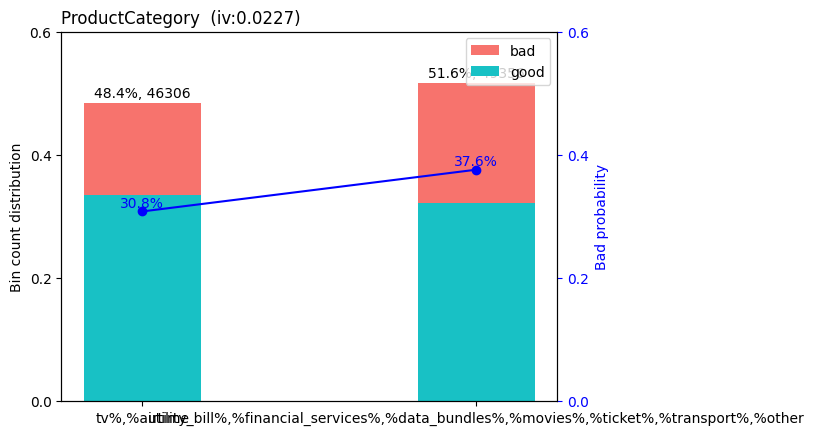

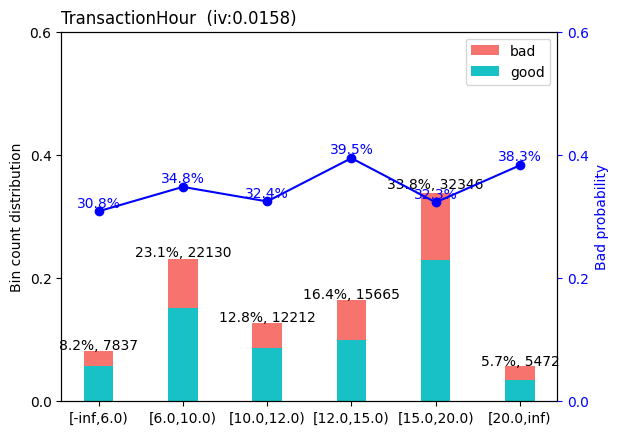

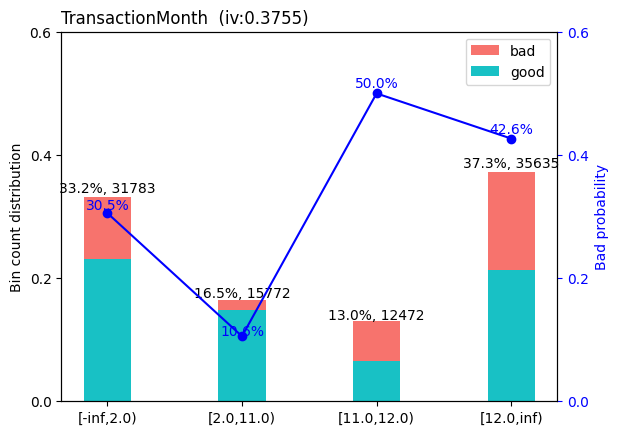

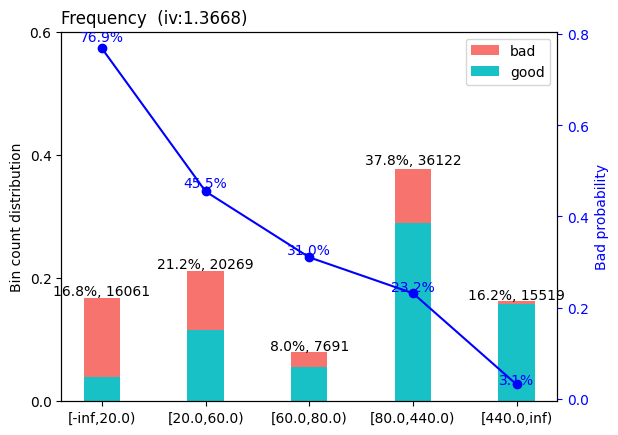

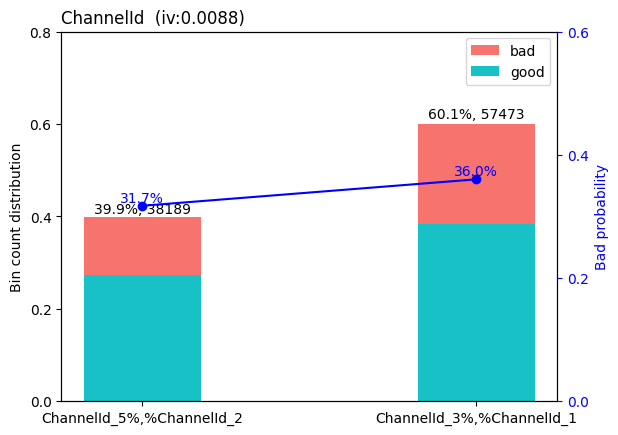

In [113]:
sc.woebin_plot(binss)

## model

In [ ]:
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report


In [ ]:
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

# Split the data
X = dff.drop('Bad',axis=1)
y = dff['Bad']
X_train, X_test, y_train, y_test = split_data(X, y)

In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)
# dt_model.fit(X_train, y_train)

In [ ]:
param_grid = {

    'max_depth': [3,5,10,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'criterion': ['gini','entropy'],
    'max_feature': ['None', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid,
                           cv=5, scoring = 'accuracy', verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

print('best hyperparamters:', grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('test accuracy', accuracy)
print('classification report:\n',classification_report(y_test, y_pred) )